### Decision trees are simple, easy to understand, interpret and visualize.
### However, for problems with more than 10-20 variables, collinearities or sparse data, the accuracy and overfitting of the method can be improved with the ensemble [random forests](https://builtin.com/data-science/random-forest-algorithm).
### **Real-life analogy:** Discussing sports or politics on a family table!!! These matters depend on thousands of different variables. Many "experts" who believe that they depend only on the 2 or 3 variables they believe in.
### **Bagging:** Every expert picks up a few variables and uses them to build a single tree. Then, you combine the knowledge of the trees ensemble and calculate the probability of a new sample by passing this sample through all the individual trees.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import the tree based methods:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [2]:
# Import data and rename column
cc_data = pd.read_excel('cc_data_uci.xls')
cc_data.rename(columns={'default payment next month': 'OUTPUT'}, inplace = True)

# Separate inputs: X and output:y
X = cc_data.drop(['OUTPUT'], axis = 1)
y = cc_data['OUTPUT']

# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/3, random_state=0)

### Now, I will built a [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) of **n_estimators = 200** individual trees for values of **max_depth** 2 to 7. Important parameters are:
### **n_estimators:** is the number of "experts" or trees that you built in the ensemble. The more estimators you create, the more accurate prediction you will make, but the longer the computation will take. After a certain number, you won't get any better in predicting, so don't overdo it.
### **max_features:** The number of features each tree considers at a split. Default value is: $\sqrt{n_{features}}$, which means $\sqrt{23}\approx5%$

In [3]:
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(2, 8)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(n_estimators = 200, max_depth = i, random_state=0))
    estimator_max_depth[i-2].fit(X_train, y_train)
    # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
    scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1]  
    # Predict the class of test set
    y_test_predicted = estimator_max_depth[i-2].predict(X_test)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
    # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    

### Tabulate and plot the performance metrics

In [4]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 2
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,80.600,0.769586,0.769136,2
1,81.355,0.774461,0.771138,3
2,81.585,0.779674,0.772370,4
3,81.665,0.789954,0.774465,5
4,82.025,0.803970,0.775437,6
5,82.205,0.822296,0.776064,7


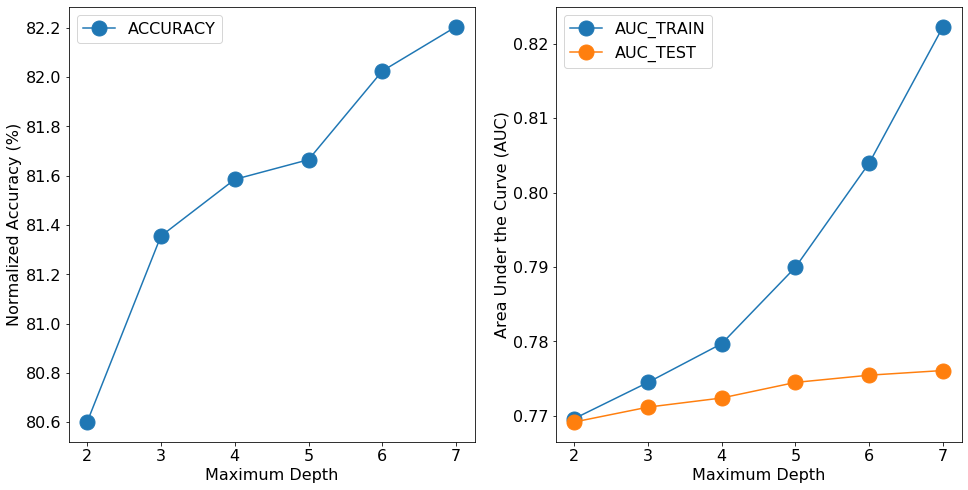

In [5]:
fig_1 = plt.figure(figsize=(16,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

### Compare the performance with the simple tree performance? Random Forests are superior in this case
### Pick max_depth=6 as my best model (why?) and calculate some metrics to compare with the simple tree

In [6]:
# Define and fit
estimator      = RandomForestClassifier(random_state=0, max_depth = 6)
rf_best_model = estimator.fit(X_train, y_train)
# Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
scores_train = rf_best_model.predict_proba(X_train)[:,1] 
scores_test  = rf_best_model.predict_proba(X_test)[:,1]  
# Predict the class of test set
y_test_predicted = rf_best_model.predict(X_test)
# Calculate accuracy at every iteration and append
accuracy = 100*accuracy_score(y_test, y_test_predicted, normalize = True)
# ROC Calc Train set 
fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
# Calculate the AUCs
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

### Plot the probabilities distribution and the ROC curves. Compare with those of simple trees.

Text(-1.8449999999999989, 0.5, 'Counts of clients')

<Figure size 360x360 with 0 Axes>

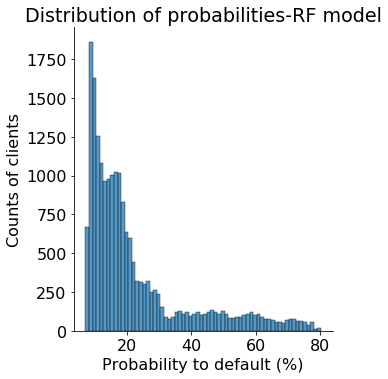

In [34]:
plt.figure(figsize=(5,5))
sns.displot(data = scores_test, x = 100*scores_test)
plt.title('Distribution of probabilities-RF model')
plt.xlabel('Probability to default (%)')
plt.ylabel('Counts of clients')

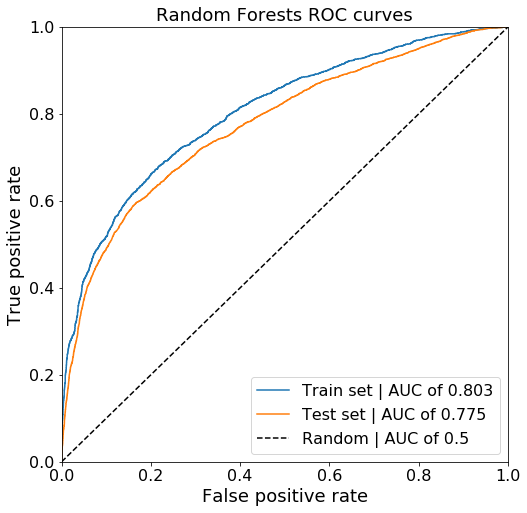

In [8]:
# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forests ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

### Feature importance

In [9]:
# Calculate feature importances
importances = rf_best_model.feature_importances_
importances

array([0.0337956 , 0.00175621, 0.00472048, 0.00325849, 0.01486565,
       0.27094868, 0.17338528, 0.08425409, 0.03292484, 0.06852558,
       0.05476783, 0.01891669, 0.01692782, 0.0194058 , 0.01719388,
       0.01896942, 0.01441117, 0.04023799, 0.02859271, 0.02286695,
       0.02046989, 0.01734936, 0.02145557])

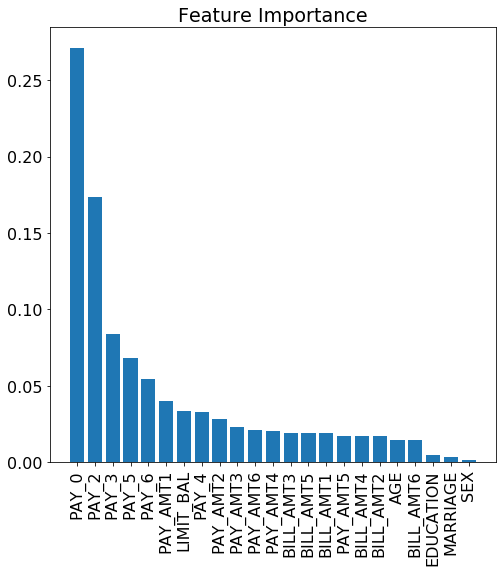

In [10]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [cc_data.columns[i] for i in indices]

# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# Show plot
plt.show()

### How are the feature importances different than the simple decision tree? There are no features with zero importance!!!

### The confusion matrix. Although the numbers seem comparable, we will show that Random Forests are superior to Simple Trees

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predicted)
print(cm)

[[15010   627]
 [ 2950  1413]]


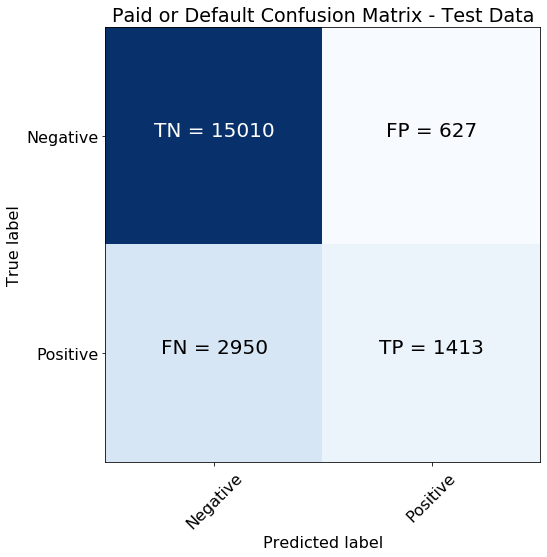

In [12]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Paid or Default Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

### Decision boundary is not linear. Notice the gradual changes in the regions.

In [13]:
xx, yy = np.mgrid[-2:8:1.1111, -2:8:1.1111] # The steps 1.1111 and 1.75 were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

# np.ones is a table full of ones with 100x23 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 23)) * np.median(X_train, axis=0) 
pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# Then, we replace the 5th and 11th column with the values of the grid
median_inputs[:,5] = grid[:,0]
median_inputs[:,6] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:13,:12] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
df.style.apply(lambda x: ['background: grey' if (x.name == 5)|(x.name == 6)  else '' for i in x])


(100, 2)


,0,1,2,3,4,5,6,7,8,9,10,11
0,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,22925.500000
1,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,-0.888900,0.000000,0.000000,0.000000,0.000000,22925.500000
2,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,0.222200,0.000000,0.000000,0.000000,0.000000,22925.500000
3,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,1.333300,0.000000,0.000000,0.000000,0.000000,22925.500000
4,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,2.444400,0.000000,0.000000,0.000000,0.000000,22925.500000
5,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,3.555500,0.000000,0.000000,0.000000,0.000000,22925.500000
6,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,4.666600,0.000000,0.000000,0.000000,0.000000,22925.500000
7,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,5.777700,0.000000,0.000000,0.000000,0.000000,22925.500000
8,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,6.888800,0.000000,0.000000,0.000000,0.000000,22925.500000
9,140000.000000,2.000000,2.000000,2.000000,34.000000,-2.000000,7.999900,0.000000,0.000000,0.000000,0.000000,22925.500000


In [14]:
probs = rf_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

[(-2, 8), Text(0, 0.5, 'PAY_2'), (-2, 8), Text(0.5, 0, 'PAY_0'), None]

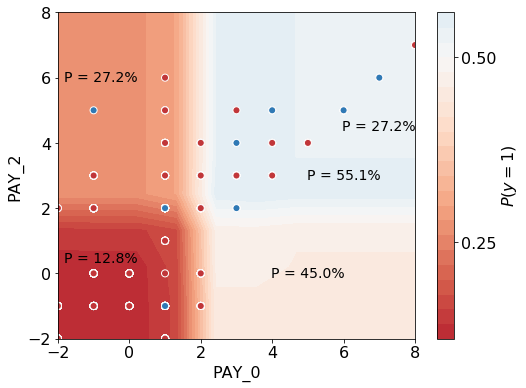

In [15]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train['PAY_0'][50:], X_train['PAY_2'][50:], c=y_train[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
plt.annotate('P = 45.0%', xy=(5,0), xycoords='data',horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
plt.annotate('P = 12.8%', xy=(-0.8,0.35), xycoords='data', horizontalalignment= 'center', fontsize = 14)
plt.annotate('P = 27.2%', xy=(-0.8,6.0), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
plt.annotate('P = 55.1%', xy=(6.0,3.0), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
plt.annotate('P = 27.2%', xy=(7.0,4.5), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(-2, 8), ylim=(-2, 8),
       xlabel="PAY_0", ylabel="PAY_2")

### **Ranking/Sorting** is very useful in many problems. E.g. prioritizing patients in a health system or customers about to attrite.
### Also, ranking helps us show why Random Forests perform better than the Tree model despite what the confusion matrix shows?

In [23]:
rf_scores_outputs = pd.DataFrame(data={'RF_scores': scores_test, 
                                       'LABEL': y_test}).sort_values(by='RF_scores', ascending=False)
rf_scores_outputs

,RF_scores,LABEL
26605,0.802051,1
28531,0.800817,1
17862,0.799309,1
20721,0.799165,1
16554,0.796942,1
...,...,...
21422,0.073159,0
7104,0.072386,0
14570,0.072386,0
12529,0.072386,0


### Rebuild the Tree-based model, score and rank the probabilities

In [24]:
estimator = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth = 6)
model_dt  = estimator.fit(X_train, y_train)
y_test_tree_proba = model_dt.predict_proba(X_test)[:,1]

In [25]:
tree_scores_outputs = pd.DataFrame(data={'Tree_scores': y_test_tree_proba, 
                                       'LABEL': y_test}).sort_values(by='Tree_scores', ascending=False)
tree_scores_outputs

,Tree_scores,LABEL
26297,1.0,1
17743,1.0,1
19249,1.0,0
17738,1.0,1
15226,1.0,1
...,...,...
27263,0.0,1
19597,0.0,0
16432,0.0,1
25913,0.0,0


Text(-1.8449999999999989, 0.5, 'Counts of clients')

<Figure size 360x360 with 0 Axes>

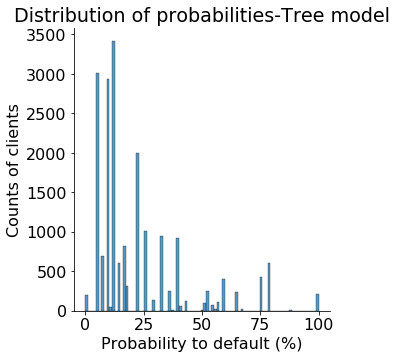

In [35]:
plt.figure(figsize=(5,5))
sns.displot(data = tree_scores_outputs['Tree_scores'], x = 100*tree_scores_outputs['Tree_scores'])
plt.title('Distribution of probabilities-Tree model')
plt.xlabel('Probability to default (%)')
plt.ylabel('Counts of clients')

### We ranked the scores from both RF and Tree model predictions while keeping the true label of every sample.
### Next, we want to calculate the cumulative sum of the positives for the ranked datasets. This number shows how many positives we got up to this point.

In [26]:
sorted_positives_rf   = rf_scores_outputs['LABEL'].cumsum()
sorted_positives_tree = tree_scores_outputs['LABEL'].cumsum()
sorted_positives_tree

26297       1
17743       2
19249       2
17738       3
15226       4
         ... 
27263    4362
19597    4362
16432    4363
25913    4363
24385    4363
Name: LABEL, Length: 20000, dtype: int64

### Also, we want to calculate the difference between the positives that the two methods catch in the sorted

In [30]:
excess_positives_of_rf = sorted_positives_rf.reset_index()-sorted_positives_tree.reset_index()
excess_positives_of_rf['LABEL'].head(20)

0     0
1     0
2     1
3     1
4     1
5     2
6     3
7     3
8     3
9     4
10    5
11    5
12    6
13    6
14    6
15    6
16    7
17    7
18    7
19    7
Name: LABEL, dtype: int64

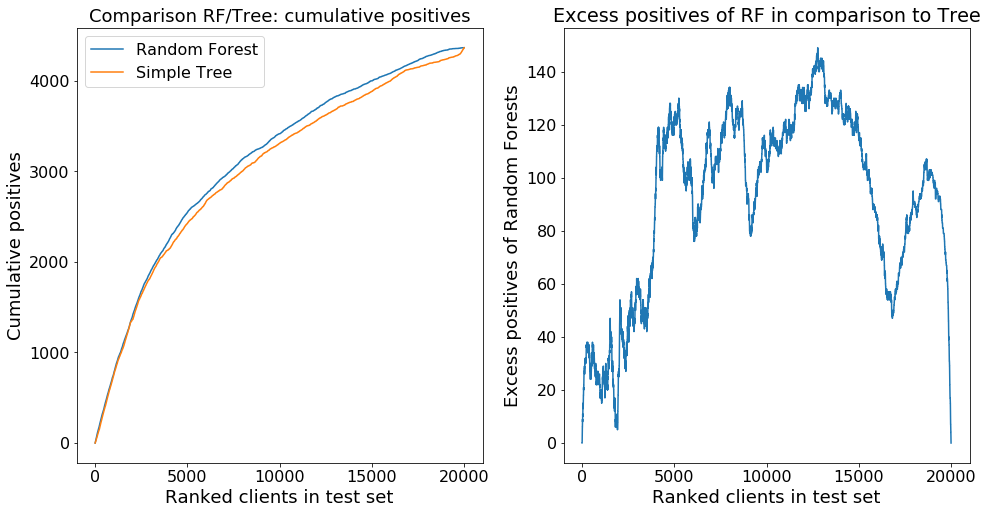

In [20]:
fig2 = plt.figure(figsize=(16,8))
# Plotting
fig2_a = plt.subplot(121)
plt.plot(range(1,20001), sorted_positives_rf, label='Random Forest');
plt.plot(range(1,20001), sorted_positives_tree, label='Simple Tree');
plt.title('Comparison RF/Tree: cumulative positives', fontsize = 18)
plt.ylabel('Cumulative positives', fontsize = 18)
plt.xlabel('Ranked clients in test set', fontsize = 18)
plt.xticks(np.arange(0,20001, step=5000))
plt.legend()

fig2_b = plt.subplot(122)
plt.plot(excess_positives_of_rf['LABEL'])
plt.title('Excess positives of RF in comparison to Tree')
plt.ylabel('Excess positives of Random Forests', fontsize = 18)
plt.xlabel('Ranked clients in test set', fontsize = 18)
plt.show()

### What is the advantage of Random Forests? It ranks the probabilities better than the Simple Tree.
### For this reason, Random Forests are better at predicting a more granular and accurate probability and therefore are superior to simple trees when an accurate probability estimate and preventing overfit is needed.